In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
import tensorflow_addons as tfa

In [3]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

TF version: 2.2.0
Hub version: 0.10.0


In [4]:
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14078421239105576368,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13228256049691220977
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9884520960
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17091729092781118946
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9731933204739676966
 physical_device_desc: "device: XLA_GPU device"]

In [6]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [136]:
# Resize to 224 first
import cv2
def resize_to_dir(rootdir, subdir, dstdir):
    olddir = os.path.join(rootdir, subdir)
    imgset = []
    for root, dirs, files in os.walk(olddir):
        for j, filename in enumerate(files):
            if '.jpg' in filename or '.png' in filename or '.bmp' in filename:
                full_path = os.path.join(root, filename)
                imgset.append(full_path)
    print("imgset N : ", len(imgset))
    rsize = (224,224)
    newdir = os.path.join(dstdir, subdir)
    if not os.path.exists(newdir):
        os.makedirs(newdir)
    
    for imgpath in imgset:
        img = cv2.imread(imgpath, cv2.IMREAD_COLOR)
        fname = os.path.basename(imgpath)
        fname_png = fname.split('.png')[0]+".png"
        resized = cv2.resize(img, rsize, interpolation = cv2.INTER_LINEAR)
        newpath = os.path.join(newdir, fname_png)
        cv2.imwrite(newpath, resized)

inscape_dir = "D:/inscape_test/C0DA01/side_side_h0_s1-i0"
inscape_newdir = "D:/experimental/cutout/data/inscape"
dworld_dir = "D:/dworld"
dworld_newdir = "D:/experimental/cutout/data/dworld"
ng_dir_train = "train/NG"
ok_dir_train = "train/OK"
ng_dir_test = "test/NG"
ok_dir_test = "test/OK"

# resize_to_dir(inscape_dir, ng_dir_test, inscape_newdir)
# resize_to_dir(inscape_dir, ng_dir_train, inscape_newdir)
# resize_to_dir(inscape_dir, ok_dir_test, inscape_newdir)
# resize_to_dir(inscape_dir, ok_dir_train, inscape_newdir)
# resize_to_dir(dworld_dir, ng_dir_test, dworld_newdir)
# resize_to_dir(dworld_dir, ng_dir_train, dworld_newdir)
# resize_to_dir(dworld_dir, ok_dir_test, dworld_newdir)
# resize_to_dir(dworld_dir, ok_dir_train, dworld_newdir)

In [137]:
fruit_dir = r"D:\fresh_and_rotten_dataset"
fruit_newdir = "D:/experimental/cutout/data/fruits"
fresh_dir_train = "train/freshapples"
rot_dir_train = "train/rottenapples"
fresh_dir_test = "test/freshapples"
rot_dir_test = "test/rottenapples"

resize_to_dir(fruit_dir, fresh_dir_train, fruit_newdir)
resize_to_dir(fruit_dir, rot_dir_train, fruit_newdir)
resize_to_dir(fruit_dir, fresh_dir_test, fruit_newdir)
resize_to_dir(fruit_dir, rot_dir_test, fruit_newdir)

imgset N :  1270
imgset N :  1757
imgset N :  395
imgset N :  601


In [180]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE+(3,),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling='avg',
)

# add a global spatial average pooling layer
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

# this is the model we will train
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [181]:

# first: train only the top layers (which were randomly initialized)
# # i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False

# # let's visualize layer names and layer indices to see how many layers
# # we should freeze:
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)

# # # we chose to train the top 2 inception blocks, i.e. we will freeze
# # # the first 249 layers and unfreeze the rest:
# for layer in model.layers[:99]:
#     layer.trainable = False
# for layer in model.layers[99:]:
#     layer.trainable = True

model.compile(
    #optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9),
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision()]
)

In [182]:
# prepare for k-fold
x1dir = os.path.join(fruit_newdir, fresh_dir_train)
x2dir = os.path.join(fruit_newdir, rot_dir_train)
x1 = []
x2 = []
for root, dirs, files in os.walk(x1dir):
    for j, filename in enumerate(files):
        if '.jpg' in filename or '.png' in filename or '.bmp' in filename:
            full_path = os.path.join(root, filename)
            x1.append(full_path)
for root, dirs, files in os.walk(x2dir):
    for j, filename in enumerate(files):
        if '.jpg' in filename or '.png' in filename or '.bmp' in filename:
            full_path = os.path.join(root, filename)
            x2.append(full_path)
            
y1 = [0 for i in range(len(x1))]
y2 = [1 for i in range(len(x2))]
X = np.asarray([*x1, *x2])
Y = np.asarray([*y1, *y2])

np.random.seed(21)
np.random.shuffle(X)
np.random.seed(21)
np.random.shuffle(Y)

In [175]:
from sklearn.preprocessing import OneHotEncoder
Y = Y.reshape(-1,1)
enc = OneHotEncoder()
enc.fit(Y)
Y_1hot = enc.transform(Y).toarray()
Y_1hot.shape

(3072, 2)

In [171]:
trainset = []
for imgpath in X:
    image = tf.keras.preprocessing.image.load_img(
        imgpath, grayscale=False, color_mode="rgb", target_size=None, interpolation="linear"
    )
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = tf.keras.applications.mobilenet_v2.preprocess_input(input_arr)
#     print(input_arr.shape)
    trainset.append(input_arr)
trainset = np.asarray(trainset)
dataset = tf.data.Dataset.from_tensor_slices(trainset)
labels = tf.data.Dataset.from_tensor_slices(Y_1hot)
dset = tf.data.Dataset.zip((dataset, labels))
dset = dset.shuffle(100).batch(64)
hist = model.fit(
    dset,
#     shuffle = True,
    epochs=25, steps_per_epoch=None,
#     validation_split=0.1
)

Epoch 1/25
48/48 [==============================] - 13s 271ms/step - loss: 0.0077 - accuracy: 0.9977 - precision_14: 0.9977
Epoch 2/25
48/48 [==============================] - 13s 278ms/step - loss: 0.0030 - accuracy: 0.9990 - precision_14: 0.9990
Epoch 3/25
48/48 [==============================] - 13s 266ms/step - loss: 0.0097 - accuracy: 0.9967 - precision_14: 0.9967
Epoch 4/25
48/48 [==============================] - 13s 272ms/step - loss: 0.0014 - accuracy: 0.9997 - precision_14: 0.9997
Epoch 5/25
48/48 [==============================] - 14s 291ms/step - loss: 5.9395e-04 - accuracy: 1.0000 - precision_14: 1.0000
Epoch 6/25
48/48 [==============================] - 13s 277ms/step - loss: 7.2241e-04 - accuracy: 0.9997 - precision_14: 0.9997
Epoch 7/25
48/48 [==============================] - 13s 275ms/step - loss: 0.0022 - accuracy: 0.9990 - precision_14: 0.9990
Epoch 8/25
48/48 [==============================] - 13s 274ms/step - loss: 4.4080e-04 - accuracy: 1.0000 - precision_14: 1.0

In [172]:
# plt.figure()
# plt.ylabel("Loss (training and validation)")
# plt.xlabel("Training Steps")
# plt.ylim([0,2])
# plt.plot(hist["loss"])
# plt.plot(hist["val_loss"])

modelname = f'model_no_fold_test.h5'
model.save_weights(f"./saved/{modelname}")

train :  2048
test :  1024
y_train [862, 1186]
y_test [426, 598]
Epoch 1/25
32/32 [==============================] - 10s 328ms/step - loss: 0.1507 - accuracy: 0.9346 - precision_15: 0.9346 - val_loss: 2.2666 - val_accuracy: 0.4961 - val_precision_15: 0.4961
Epoch 2/25
32/32 [==============================] - 10s 310ms/step - loss: 0.0054 - accuracy: 0.9990 - precision_15: 0.9990 - val_loss: 2.3230 - val_accuracy: 0.5088 - val_precision_15: 0.5088
Epoch 3/25
32/32 [==============================] - 10s 309ms/step - loss: 0.0013 - accuracy: 1.0000 - precision_15: 1.0000 - val_loss: 2.2890 - val_accuracy: 0.5234 - val_precision_15: 0.5234
Epoch 4/25
32/32 [==============================] - 10s 308ms/step - loss: 7.8690e-04 - accuracy: 1.0000 - precision_15: 1.0000 - val_loss: 2.1512 - val_accuracy: 0.5391 - val_precision_15: 0.5391
Epoch 5/25
32/32 [==============================] - 10s 309ms/step - loss: 5.8117e-04 - accuracy: 1.0000 - precision_15: 1.0000 - val_loss: 2.0313 - val_accura

Epoch 17/25
32/32 [==============================] - 10s 310ms/step - loss: 1.9249e-05 - accuracy: 1.0000 - precision_15: 1.0000 - val_loss: 0.0539 - val_accuracy: 0.9834 - val_precision_15: 0.9834
Epoch 18/25
32/32 [==============================] - 10s 309ms/step - loss: 1.8052e-05 - accuracy: 1.0000 - precision_15: 1.0000 - val_loss: 0.0469 - val_accuracy: 0.9854 - val_precision_15: 0.9854
Epoch 19/25
32/32 [==============================] - 10s 318ms/step - loss: 1.6978e-05 - accuracy: 1.0000 - precision_15: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9883 - val_precision_15: 0.9883
Epoch 20/25
32/32 [==============================] - 10s 317ms/step - loss: 1.6013e-05 - accuracy: 1.0000 - precision_15: 1.0000 - val_loss: 0.0355 - val_accuracy: 0.9902 - val_precision_15: 0.9902
Epoch 21/25
32/32 [==============================] - 10s 324ms/step - loss: 1.5139e-05 - accuracy: 1.0000 - precision_15: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9912 - val_precision_15: 0.9912
Epoch 22/2

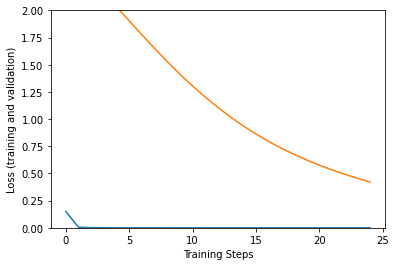

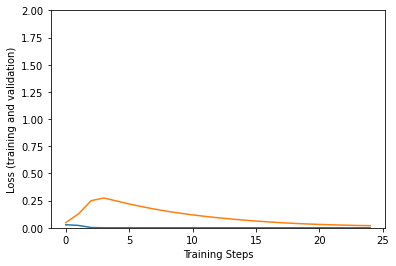

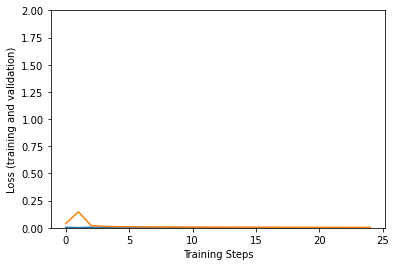

In [183]:
scores = []

def count_class(y):
    cnts = [0,0]
    for onehot in y:
        onehot = onehot.tolist()
        ind = onehot.index(1.0)
        cnts[ind] += 1
    return cnts

from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
kf.get_n_splits(X)
for k, (train_index, test_index) in enumerate(kf.split(X)):
    print("train : ", len(train_index))
    print("test : ", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y_1hot[train_index], Y_1hot[test_index]
    
    print("y_train", count_class(y_train))
    print("y_test", count_class(y_test))
    
    trainset = []
    for imgpath in X_train:
        image = tf.keras.preprocessing.image.load_img(
            imgpath, grayscale=False, color_mode="rgb", target_size=None, interpolation="linear"
        )
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        input_arr = tf.keras.applications.mobilenet_v2.preprocess_input(input_arr)
        trainset.append(input_arr)
    trainset = np.asarray(trainset)
    train_dataset = tf.data.Dataset.from_tensor_slices(trainset)
    train_labels = tf.data.Dataset.from_tensor_slices(y_train)
    train = tf.data.Dataset.zip((train_dataset, train_labels))
    train = train.batch(64)
    
    valset = []
    for imgpath in X_test:
        image = tf.keras.preprocessing.image.load_img(
            imgpath, grayscale=False, color_mode="rgb", target_size=None, interpolation="linear"
        )
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        input_arr = tf.keras.applications.mobilenet_v2.preprocess_input(input_arr)
        valset.append(input_arr)
    valset = np.asarray(valset)
    val_dataset = tf.data.Dataset.from_tensor_slices(valset)
    val_labels = tf.data.Dataset.from_tensor_slices(y_test)
    val = tf.data.Dataset.zip((val_dataset, val_labels))
    val = val.shuffle(100).batch(64)
    
    steps_per_epoch = len(X_train) // train_generator.batch_size
    validation_steps = len(X_test) // val_generator.batch_size
    hist = model.fit(
        train,
        epochs=25, steps_per_epoch=steps_per_epoch,
        validation_data=val,
        validation_steps=validation_steps
    ).history
    
    plt.figure()
    plt.ylabel("Loss (training and validation)")
    plt.xlabel("Training Steps")
    plt.ylim([0,2])
    plt.plot(hist["loss"])
    plt.plot(hist["val_loss"])

    modelname = f'model_fold_{k}.h5'
    model.save_weights(f"./saved/{modelname}")
    
    losses = hist['val_loss']
    scores.append(min(losses))

In [184]:
# make prediction
max_fold = scores.index(min(scores))
weight_path = f"./saved/model_fold_{max_fold}.h5"
# weight_path = "./saved/model_no_fold_test.h5"
model.load_weights(weight_path)
# print("max_fold : ", max_fold)
def decode_pred(val):
    probs = val[0]
    ind = np.argmax(probs)
    return ind, probs[ind]

rootdir = os.path.join(fruit_newdir, rot_dir_test)
imglist = os.listdir(rootdir)
correct = 0
for f in imglist:
    img_path = os.path.join(rootdir, f)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    preds = model.predict(x)
    pred_cls, prob = decode_pred(preds)
    if pred_cls == 1:
        correct += 1

prec = correct/len(imglist)
print(prec)
    

0.9936305732484076


In [61]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = DenseNet121(weights='imagenet')

img_path = r'D:\experimental\cutout\data\tmp\_0_5457.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predic

40960/35363 [==================================] - 0s 2us/step
Predicted: [('n06359193', 'web_site', 0.6504205), ('n03196217', 'digital_clock', 0.32430884), ('n02708093', 'analog_clock', 0.022375515)]
